# Interactive Charts with Google Charting APIs

Google Cloud Datalab provides functionality to easily use the Google Charting API to produce interactive, JavaScript and SVG-based charts from your data, whether your data was loaded from BigQuery, CSV files, or another source loaded into a vanilla Python list.

These charts can be produced through the `%%chart` command.

## The Chart Command

In [1]:
%%chart --help

usage: %%chart [-h]
               {annotation,area,bars,bubbles,calendar,candlestick,columns,combo,gauge,geo,heatmap,histogram,line,map,org,paged_table,pie,sankey,scatter,stepped_area,table,timeline,treemap}
               ...

Generate an inline chart using Google Charts using the data in a Table, Query,
dataframe, or list. Numerous types of charts are supported. Options for the
charts can be specified in the cell body using YAML or JSON.

positional arguments:
  {annotation,area,bars,bubbles,calendar,candlestick,columns,combo,gauge,geo,heatmap,histogram,line,map,org,paged_table,pie,sankey,scatter,stepped_area,table,timeline,treemap}
                        commands
    annotation          Generate a annotation chart.
    area                Generate a area chart.
    bars                Generate a bars chart.
    bubbles             Generate a bubbles chart.
    calendar            Generate a calendar chart.
    candlestick         Generate a candlestick chart.
    columns          

As you can see, a variety of chart types are supported.

In [2]:
%%chart line --help

usage: %%chart line [-h] [-f FIELDS] -d DATA

Generate a line chart.

optional arguments:
  -h, --help            show this help message and exit
  -f FIELDS, --fields FIELDS
                        The field(s) to include in the chart
  -d DATA, --data DATA  The name of the variable referencing the Table or
                        Query to chart
None


The data to be charted is passed in as an argument.

Columns in data must be in a specific order according to the chart type. The --field argument, which takes a comma-separated list of field names, allows specifying the ordered set of columns to chart.

The body of the cell can include additional chart-specific options to pass to the chart.

# Line Chart

In [5]:
%%bq query --name timeseries
SELECT timestamp, AVG(latency) AS latency FROM (
  SELECT TIMESTAMP_TRUNC(timestamp, HOUR) AS timestamp, latency
  FROM `cloud-datalab-samples.httplogs.logs_20140615`
  WHERE endpoint = 'Popular'
)
GROUP BY timestamp
ORDER BY timestamp

In [6]:
%bq execute -q timeseries

getting params..
params: {}


timestamp,latency
2014-06-15 07:00:00,306.515555556
2014-06-15 08:00:00,303.367768595
2014-06-15 09:00:00,326.505050505
2014-06-15 10:00:00,322.016574586
2014-06-15 11:00:00,322.518918919
2014-06-15 12:00:00,333.432835821
2014-06-15 13:00:00,289.668122271
2014-06-15 14:00:00,280.78700361
2014-06-15 15:00:00,305.483552632
2014-06-15 16:00:00,248.8828125


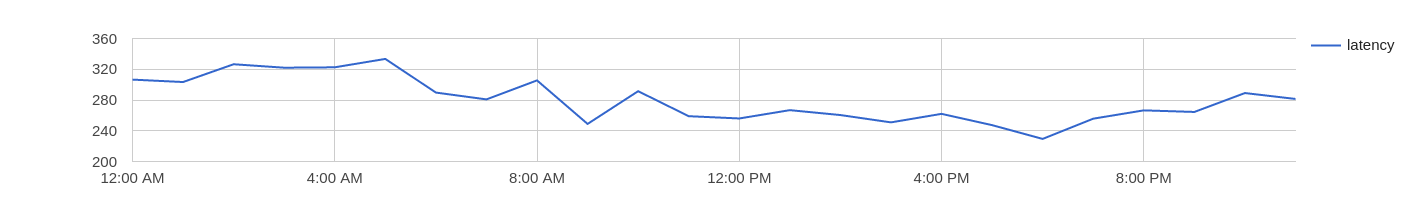

In [7]:
%%chart line --fields timestamp,latency --data timeseries

Bar charts and column charts are similar to line charts.

# Scatter Chart

In [8]:
%%bq query -n births
SELECT gestation_weeks AS weeks, weight_pounds AS weight
FROM `publicdata.samples.natality`
WHERE gestation_weeks < 99
LIMIT 1000

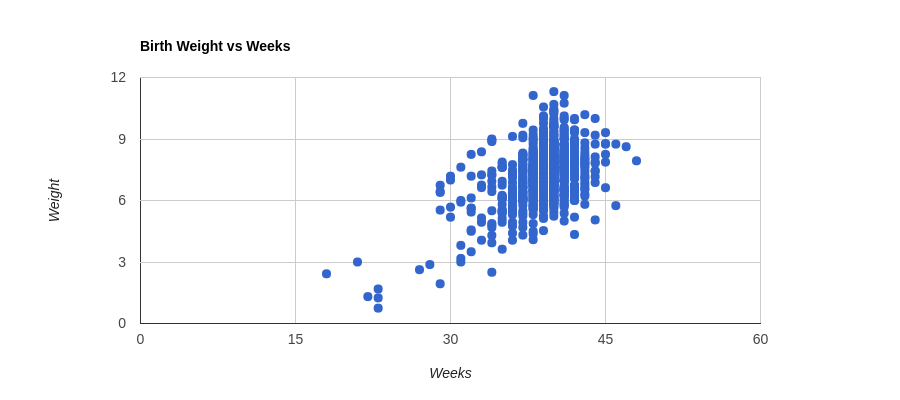

In [9]:
%%chart scatter --data births
title: Birth Weight vs Weeks
height: 400
width: 900
hAxis:
  title: Weeks
vAxis:
  title: Weight
legend: none

# Pie Chart

In [10]:
%%bq query -n languages
SELECT repository_language AS language, COUNT(repository_language) as activity
FROM `publicdata.samples.github_timeline`
WHERE type = 'PushEvent'
  AND repository_language != ''
GROUP BY language
ORDER BY activity DESC
LIMIT 10

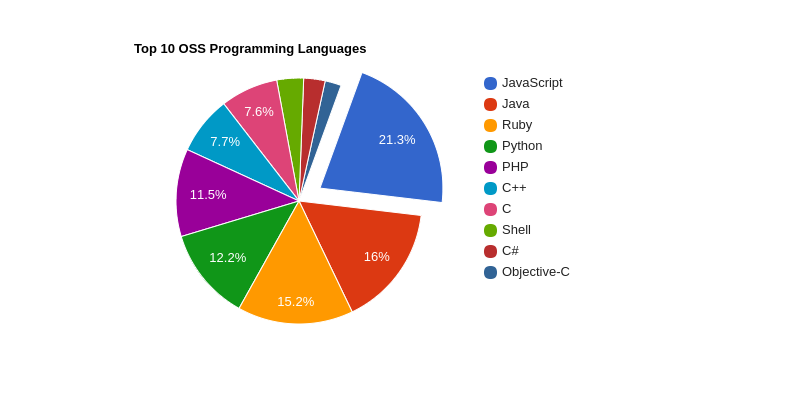

In [11]:
%%chart pie --fields language,activity --data languages
title: Top 10 OSS Programming Languages
height: 400
width: 800
pieStartAngle: 20
slices:
  0:
    offset: .2

# TimeSeries Chart

In [22]:
%%bq query -n weather
SELECT max_temperature AS temperature,
       SAFE_CAST(CONCAT(SAFE_CAST(year AS STRING), '-', SAFE_CAST(month AS STRING), '-', SAFE_CAST(day AS STRING)) AS TIMESTAMP) AS timestamp
FROM `publicdata.samples.gsod`
WHERE station_number = 727930 AND year >= 2000
ORDER BY year DESC, month DESC, day DESC

In [23]:
%%chart annotation --fields timestamp,temperature --data weather

# Geo Chart

In [1]:
%%bq query -n locations
SELECT SAFE_CAST(pickup_latitude AS FLOAT64) AS lat, SAFE_CAST(pickup_longitude AS FLOAT64) AS lon, medallion
FROM `833682135931.nyctaxi.trip_data`

In [2]:
%%bq query -n geohashes --subqueries locations
SELECT lat, lon,
       CONCAT(SAFE_CAST(FLOOR(lat*1000+0.5)/1000 AS STRING), ':', SAFE_CAST(FLOOR(lon*1000+0.5)/1000 AS STRING)) AS geoid,
       medallion
FROM locations
WHERE lat != 0 AND lon != 0

In [3]:
%%bq query -n hotspots --subqueries geohashes
SELECT ANY_VALUE(lat) AS lat, ANY_VALUE(lon) AS lon, COUNT(medallion) AS pickups
FROM geohashes
WHERE MOD(ABS(FARM_FINGERPRINT(medallion)), 1000) = 1
GROUP BY geoid
ORDER BY pickups DESC
LIMIT 25

In [4]:
%%chart map --fields lat,lon,pickups --data hotspots
showTip: true
mapType: normal